In [2]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool, cpu_count

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

In [ ]:
dfAll = pd.read_pickle("PklData/AllData.pkl")
dfAll.head()

In [ ]:
df_actual = dfAll[(dfAll.Actual_Data == True) & (dfAll.Is_Pause == False)]
df_actual.head()

In [ ]:
print("all: %s, actual data: %s" % (len(dfAll), len(df_actual)))

In [ ]:
%%time
df_filtered = df_actual.copy(deep=True)
for User in df_filtered.userID.unique():
    print(User)
    for Task in df_filtered.TaskID.unique():
        for Version in df_filtered.VersionID.unique():
            max_rep = df_filtered[(df_filtered.userID == User) & (df_filtered.TaskID == Task) & (df_filtered.VersionID == Version)].RepetitionID.max()
            df_filtered = df_filtered.drop(df_filtered[(df_filtered.userID == User) & (df_filtered.TaskID == Task) & (df_filtered.VersionID == Version) & (df_filtered.RepetitionID != max_rep)].index)

In [ ]:
df_filtered.to_pickle("PklData/dfFiltered.pkl")

In [ ]:
print("actual: %s, filtered data: %s" % (len(df_actual), len(df_filtered)))

In [3]:
df_filtered = pd.read_pickle("PklData/dfFiltered.pkl")

In [4]:
df_filtered.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
5511,2,1545154138673,1,680,20,2,1,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5512,2,1545154138713,1,680,20,2,1,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5513,2,1545154138755,1,680,20,2,1,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5514,2,1545154138803,1,680,20,2,1,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5515,2,1545154138846,1,680,20,2,1,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ..."


In [5]:
df_filtered.Image = df_filtered.Image.apply(lambda x: x.reshape(27, 15))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.clip(min=0, max=255))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.astype(np.uint8))
df_filtered["ImageSum"] = df_filtered.Image.apply(lambda x: np.sum(x))

In [6]:
#Svens new Blob detection
def detect_blobs(image, task):
    #image = e.Image
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = np.copy(image)
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 200, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstMin = []
    lstMax = []
    count = 0
    contours.sort(key=lambda a: cv2.contourArea(a))
    if len(contours) > 0:
        # if two finger or knuckle
        cont_count = 2 if task in [6, 7, 23, 24] and len(contours) > 1 else 1
        for i in range(1, cont_count + 1):
            max_contour = contours[-1 * i]
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            #croped_im = np.zeros((27,15))
            blob = large[max(ymin - 1, 0):min(ymax + 1, large.shape[0]),max(xmin - 1, 0):min(xmax + 1, large.shape[1])]
            #croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
            #return (1, [croped_im])
            lstBlob.append(blob)
            lstMin.append(xmax-xmin)
            lstMax.append(ymax-ymin)
            count = count + 1
        return (count, lstBlob, lstMin, lstMax)
    else:
        return (0, [np.zeros((29, 19))], 0, 0)

In [7]:
%%time
pool = Pool(8)
temp_blobs = pool.starmap(detect_blobs, zip(df_filtered.Image, df_filtered.TaskID)) #[["Image", "TaskID"]])
pool.close()

CPU times: user 4.69 s, sys: 2.86 s, total: 7.55 s
Wall time: 8.29 s


In [8]:
df_filtered["BlobCount"] = [a[0] for a in temp_blobs]
df_filtered["BlobImages"] = [a[1] for a in temp_blobs]
df_filtered["BlobW"] = [a[2] for a in temp_blobs]
df_filtered["BlobH"] = [a[3] for a in temp_blobs]

In [9]:
df_filtered.BlobCount.value_counts()

0    274057
1     94448
2      8652
Name: BlobCount, dtype: int64

In [10]:
df_filtered = df_filtered[(df_filtered.BlobCount == 1) | (df_filtered.BlobCount == 2)]

In [11]:
dfX = df_filtered[(df_filtered.BlobCount == 1)].copy(deep=True)
dfX.BlobImages = dfX.BlobImages.apply(lambda x : x[0])
dfX.BlobW = dfX.BlobW.apply(lambda x : x[0])
dfX.BlobH = dfX.BlobH.apply(lambda x : x[0])

dfY = df_filtered[(df_filtered.BlobCount == 2)].copy(deep=True)
dfY.BlobImages = dfY.BlobImages.apply(lambda x : x[0])
dfY.BlobW = dfY.BlobW.apply(lambda x : x[0])
dfY.BlobH = dfY.BlobH.apply(lambda x : x[0])

dfZ = df_filtered[(df_filtered.BlobCount == 2)].copy(deep=True)
dfZ.BlobImages = dfZ.BlobImages.apply(lambda x : x[1])
dfZ.BlobW = dfZ.BlobW.apply(lambda x : x[1])
dfZ.BlobH = dfZ.BlobH.apply(lambda x : x[1])

dfX = dfX.append([dfY, dfZ])

In [12]:
df_filtered = dfX

In [13]:
df_filtered["BlobArea"] = df_filtered["BlobW"]* df_filtered["BlobH"]

In [14]:
print(len(df_filtered[df_filtered.BlobCount > 0]))
df = df_filtered[df_filtered.BlobCount > 0].copy(deep=True)
print(len(df_filtered))

111752
111752


In [15]:
df.BlobArea.describe().round(1)

count    111752.0
mean         13.5
std           4.9
min           8.0
25%           9.0
50%          12.0
75%          16.0
max          88.0
Name: BlobArea, dtype: float64

In [16]:
df["BlobSum"] = df.BlobImages.apply(lambda x: np.sum(x))

In [17]:
df.BlobSum.describe()

count    111752.000000
mean       1017.860960
std         430.365029
min         213.000000
25%         740.000000
50%         940.000000
75%        1182.000000
max        6705.000000
Name: BlobSum, dtype: float64

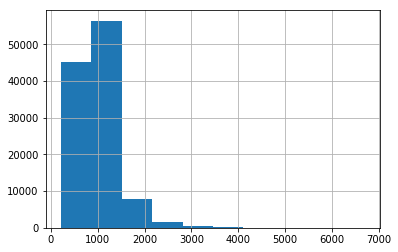

In [18]:
df.BlobSum.hist()

In [19]:
#Small / Blobs where the pixels are only a "little" hit
dfX = df[df.BlobSum <= 255]
len(dfX)

3

In [20]:
#Augmenting by flipping in both axis (datax4)
df["Version"] = "Normal"
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.flipud(x))
dfFlipped["Version"] = "FlippedUD"
df = df.append(dfFlipped)
dfFlipped = df.copy(deep=True)
dfFlipped.BlobImages = dfFlipped.BlobImages.apply(lambda x: np.fliplr(x))
dfFlipped["Version"] = "FlippedLR"
df = df.append(dfFlipped)

In [21]:
def pasteToEmpty (blob):
    croped_im = np.zeros((27,15))
    croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
    return croped_im

In [22]:
df["Blobs"] = df.BlobImages.apply(lambda x: pasteToEmpty(x))

In [23]:
#Label if knuckle or finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df['InputMethod'] = df.apply(f, axis=1)

In [24]:
df[["userID", "TaskID", "Version", "Blobs", "InputMethod"]].to_pickle("PklData/df_blobs.pkl")

In [25]:
df[["userID", "TaskID", "Version", "Blobs", "InputMethod", "BlobArea"]].to_pickle("PklData/df_blobs_area.pkl")

In [26]:
#glaube das war alt
#df_blobs = df_croped[df_croped.BlobCount == 1]
#print("detected blobs: %s" % len(df_blobs))
#df_blobs.head()

In [27]:
#df_blobs.to_pickle("PklData/df_blobs.pkl")

# display blobs

NameError: name 'df_blobs' is not defined

<Figure size 432x288 with 0 Axes>

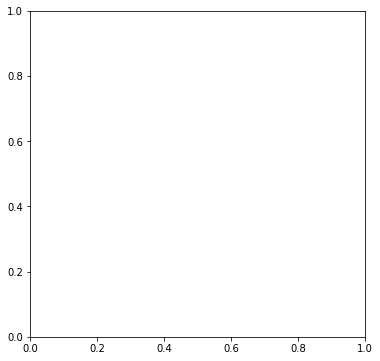

In [28]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = 1000
data = df_blobs.Blobs.iloc[data_point][0]
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
# plt.savefig("input.png", bbox_inches='tight')
plt.show()

In [29]:
df_blobs.userID.unique()

NameError: name 'df_blobs' is not defined